# Comprehensive Analysis of Mental Health Dataset

## About Dataset

The Dataset for Mental Health is an invaluable asset in the realm of natural language processing (NLP), providing a structured foundation for the development of sophisticated mental health assistants. This dataset exemplifies the variety of user inputs of according to different different Mental Health conditions. Each category within the dataset—'greeting', 'morning', 'afternoon', 'evening', 'night', 'goodbye', 'thanks', 'no-response', 'neutral-response', 'about', 'skill', 'creation', 'name', 'help', 'sad', 'stressed', 'worthless', 'depressed', 'happy', 'casual', 'anxious', 'not-talking', 'sleep', 'scared', 'death', 'understand', 'done', 'suicide', 'hate-you', 'hate-me', 'default', 'jokes', 'repeat', 'wrong', 'stupid', 'location', 'something-else', 'friends', 'ask', 'problem', 'no-approach', 'learn-more', 'user-agree', 'meditation', 'user-meditation', 'pandora-useful', 'user-advice', 'learn-mental-health', 'mental-health-fact', 'fact-1', 'fact-2', 'fact-3', to 'fact-32'—has been carefully curated to encompass a diverse range of expressions, ensuring that the resulting models are versatile and robust. This scientific approach not only enhances the dataset's diversity to record user inputs and responses to user inputs accurately but also contributes to the broader field of AI-driven health technologies, pushing the boundaries of what conversational health assistants can achieve.

## Importing Required Libraries

In [39]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import GridSearchCV, cross_val_score
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, SpatialDropout1D
from tensorflow.keras.utils import to_categorical

nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to C:\Users\Debjit
[nltk_data]     Mandal\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Debjit
[nltk_data]     Mandal\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

##  Dataset Loading 

In [4]:
with open('data/KB.json', 'r') as file:
    data = json.load(file)

tags = []
patterns = []
responses = []

for intent in data['intents']:
    for pattern in intent['patterns']:
        tags.append(intent['tag'])
        patterns.append(pattern)
        if 'responses' in intent:
            responses.append(intent['responses'][0])
        else:
            responses.append(None)

df = pd.DataFrame({'tag': tags, 'pattern': patterns, 'response': responses})
df.head()

,tag,pattern,response
0,greeting,Hi,Hello there. Tell me how are you feeling today?
1,greeting,Hey,Hello there. Tell me how are you feeling today?
2,greeting,Is anyone there?,Hello there. Tell me how are you feeling today?
3,greeting,Hi there,Hello there. Tell me how are you feeling today?
4,greeting,Hello,Hello there. Tell me how are you feeling today?


##  Data Exploration

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6255 entries, 0 to 6254
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   tag               6255 non-null   object
 1   pattern           6255 non-null   object
 2   response          5609 non-null   object
 3   pattern_cleaned   6255 non-null   object
 4   response_cleaned  6255 non-null   object
dtypes: object(5)
memory usage: 244.5+ KB
None
              tag                                           pattern  \
count        6255                                              6255   
unique         80                                              3163   
top     worthless  I'm not good enough for anyone to care about me.   
freq         1107                                                69   

                                        response             pattern_cleaned  \
count                                       5609                        6255   
unique   

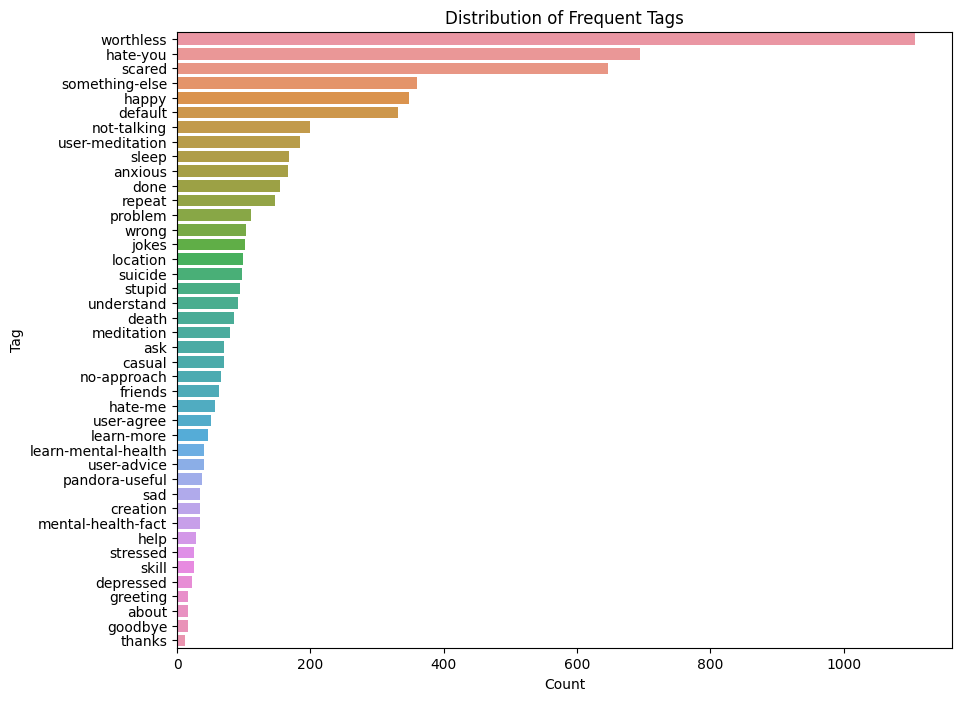

In [48]:
print(df.info())
print(df.describe())
print(df['tag'].value_counts())

min_count = 10 
tag_counts = df['tag'].value_counts()
filtered_tags = tag_counts[tag_counts >= min_count].index

plt.figure(figsize=(10, 8))
sns.countplot(y=df[df['tag'].isin(filtered_tags)]['tag'], order=tag_counts[filtered_tags].index)
plt.title('Distribution of Frequent Tags')
plt.xlabel('Count')
plt.ylabel('Tag')
plt.show()

## Data Preprocessing

In [12]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    text = text.lower()
    text = ''.join([char for char in text if char.isalpha() or char == ' '])
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words])
    return text

df['pattern_cleaned'] = df['pattern'].apply(preprocess_text)
df['response_cleaned'] = df['response'].apply(lambda x: preprocess_text(x) if x else "")

df.head()

,tag,pattern,response,pattern_cleaned,response_cleaned
0,greeting,Hi,Hello there. Tell me how are you feeling today?,hi,hello tell feeling today
1,greeting,Hey,Hello there. Tell me how are you feeling today?,hey,hello tell feeling today
2,greeting,Is anyone there?,Hello there. Tell me how are you feeling today?,anyone,hello tell feeling today
3,greeting,Hi there,Hello there. Tell me how are you feeling today?,hi,hello tell feeling today
4,greeting,Hello,Hello there. Tell me how are you feeling today?,hello,hello tell feeling today


## Feature Extraction

In [13]:
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(df['pattern_cleaned']).toarray()
y = df['tag']

from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(5004, 1752) (1251, 1752)
(5004,) (1251,)


## Model Training 

### Training of a Naive Bayes model

In [14]:
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)
nb_pred = nb_model.predict(X_test)


### Training of a SVM model

In [15]:
svm_model = SVC(kernel='linear')
svm_model.fit(X_train, y_train)
svm_pred = svm_model.predict(X_test)


### Training of a Random Forest model

In [16]:
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)


### Grid Search for hyperparameter tuning

In [17]:
param_grid = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}
grid_search = GridSearchCV(SVC(), param_grid, refit=True, verbose=2)
grid_search.fit(X_train, y_train)
svm_best = grid_search.best_estimator_


Fitting 5 folds for each of 6 candidates, totalling 30 fits


C:\Users\Debjit Mandal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


[CV] END ...............................C=0.1, kernel=linear; total time=  28.8s
[CV] END ...............................C=0.1, kernel=linear; total time=  31.1s
[CV] END ...............................C=0.1, kernel=linear; total time=  39.0s
[CV] END ...............................C=0.1, kernel=linear; total time=  30.2s
[CV] END ...............................C=0.1, kernel=linear; total time=  34.4s
[CV] END ..................................C=0.1, kernel=rbf; total time=  42.3s
[CV] END ..................................C=0.1, kernel=rbf; total time=  41.5s
[CV] END ..................................C=0.1, kernel=rbf; total time=  37.5s
[CV] END ..................................C=0.1, kernel=rbf; total time=  37.7s
[CV] END ..................................C=0.1, kernel=rbf; total time=  37.4s
[CV] END .................................C=1, kernel=linear; total time=  22.3s
[CV] END .................................C=1, kernel=linear; total time=  22.1s
[CV] END ...................

### Cross-validation

In [18]:
nb_cv_scores = cross_val_score(nb_model, X, y, cv=5)
svm_cv_scores = cross_val_score(svm_best, X, y, cv=5)
rf_cv_scores = cross_val_score(rf_model, X, y, cv=5)


C:\Users\Debjit Mandal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\Debjit Mandal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\Debjit Mandal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


## Model Evaluation

In [40]:
def evaluate_model(model, X_test, y_test, y_pred):
    unique_labels = np.unique(np.concatenate((y_test, y_pred)))
    target_names = label_encoder.inverse_transform(unique_labels)
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred, target_names=target_names, zero_division=0))



### Evaluation of a Naive Bayes model

In [41]:

print("Naive Bayes Model")
evaluate_model(nb_model, X_test, y_test, nb_pred)
print("Cross-validation scores:", nb_cv_scores)
print("Mean CV score:", np.mean(nb_cv_scores))


Naive Bayes Model
Accuracy: 0.7426059152677857
Confusion Matrix:
 [[  0   0   0 ...   0   2   0]
 [  0   0   0 ...   0   1   0]
 [  0   0  17 ...   0   1   0]
 ...
 [  0   0   0 ...  34   0   0]
 [  0   0   0 ...   0 230   0]
 [  0   0   0 ...   0   2  15]]
Classification Report:
                      precision    recall  f1-score   support

              about       0.00      0.00      0.00         4
          afternoon       0.00      0.00      0.00         1
            anxious       1.00      0.53      0.69        32
                ask       1.00      0.53      0.70        15
             casual       0.00      0.00      0.00        14
           creation       0.00      0.00      0.00         6
              death       1.00      0.87      0.93        15
            default       0.79      0.79      0.79        56
          depressed       0.00      0.00      0.00         7
               done       0.92      0.71      0.80        34
            evening       0.00      0.00      

### Evaluation of a SVM model

In [42]:

print("\nSVM Model")
evaluate_model(svm_model, X_test, y_test, svm_pred)
print("Cross-validation scores:", svm_cv_scores)
print("Mean CV score:", np.mean(svm_cv_scores))



SVM Model
Accuracy: 0.8689048760991207
Confusion Matrix:
 [[  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0  31 ...   0   0   0]
 ...
 [  0   0   0 ...  34   0   0]
 [  0   0   0 ...   0 228   0]
 [  0   0   0 ...   0   0  15]]
Classification Report:
                      precision    recall  f1-score   support

              about       0.00      0.00      0.00         4
          afternoon       0.00      0.00      0.00         1
            anxious       0.97      0.97      0.97        32
                ask       0.93      0.93      0.93        15
             casual       0.38      0.36      0.37        14
           creation       0.25      0.17      0.20         6
              death       0.94      1.00      0.97        15
            default       0.48      0.96      0.64        56
          depressed       0.00      0.00      0.00         7
               done       0.93      0.76      0.84        34
            evening       0.00      0.00      0.00   

### Evaluation of a Random Forest model

In [43]:

print("\nRandom Forest Model")
evaluate_model(rf_model, X_test, y_test, rf_pred)
print("Cross-validation scores:", rf_cv_scores)
print("Mean CV score:", np.mean(rf_cv_scores))



Random Forest Model
Accuracy: 0.86810551558753
Confusion Matrix:
 [[  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0  32 ...   0   0   0]
 ...
 [  0   0   0 ...  34   0   0]
 [  0   0   0 ...   0 227   0]
 [  0   0   0 ...   0   1  16]]
Classification Report:
                      precision    recall  f1-score   support

              about       0.00      0.00      0.00         4
          afternoon       0.00      0.00      0.00         1
            anxious       0.97      1.00      0.98        32
                ask       0.93      0.93      0.93        15
             casual       0.19      0.79      0.31        14
           creation       0.25      0.17      0.20         6
              death       1.00      1.00      1.00        15
            default       0.94      0.84      0.89        56
          depressed       1.00      0.14      0.25         7
               done       0.96      0.74      0.83        34
            evening       0.00      0.00     

## Best Prediction

In [44]:

print("\nBest SVM Model (Grid Search)")
svm_best_pred = svm_best.predict(X_test)
evaluate_model(svm_best, X_test, y_test, svm_best_pred)



Best SVM Model (Grid Search)
Accuracy: 0.8689048760991207
Confusion Matrix:
 [[  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0  31 ...   0   0   0]
 ...
 [  0   0   0 ...  34   0   0]
 [  0   0   0 ...   0 228   0]
 [  0   0   0 ...   0   0  15]]
Classification Report:
                      precision    recall  f1-score   support

              about       0.00      0.00      0.00         4
          afternoon       0.00      0.00      0.00         1
            anxious       0.97      0.97      0.97        32
                ask       0.93      0.93      0.93        15
             casual       0.38      0.36      0.37        14
           creation       0.25      0.17      0.20         6
              death       0.94      1.00      0.97        15
            default       0.48      0.96      0.64        56
          depressed       0.00      0.00      0.00         7
               done       0.93      0.76      0.84        34
            evening       0.00    

## Visualization of confusion matrix for the best model

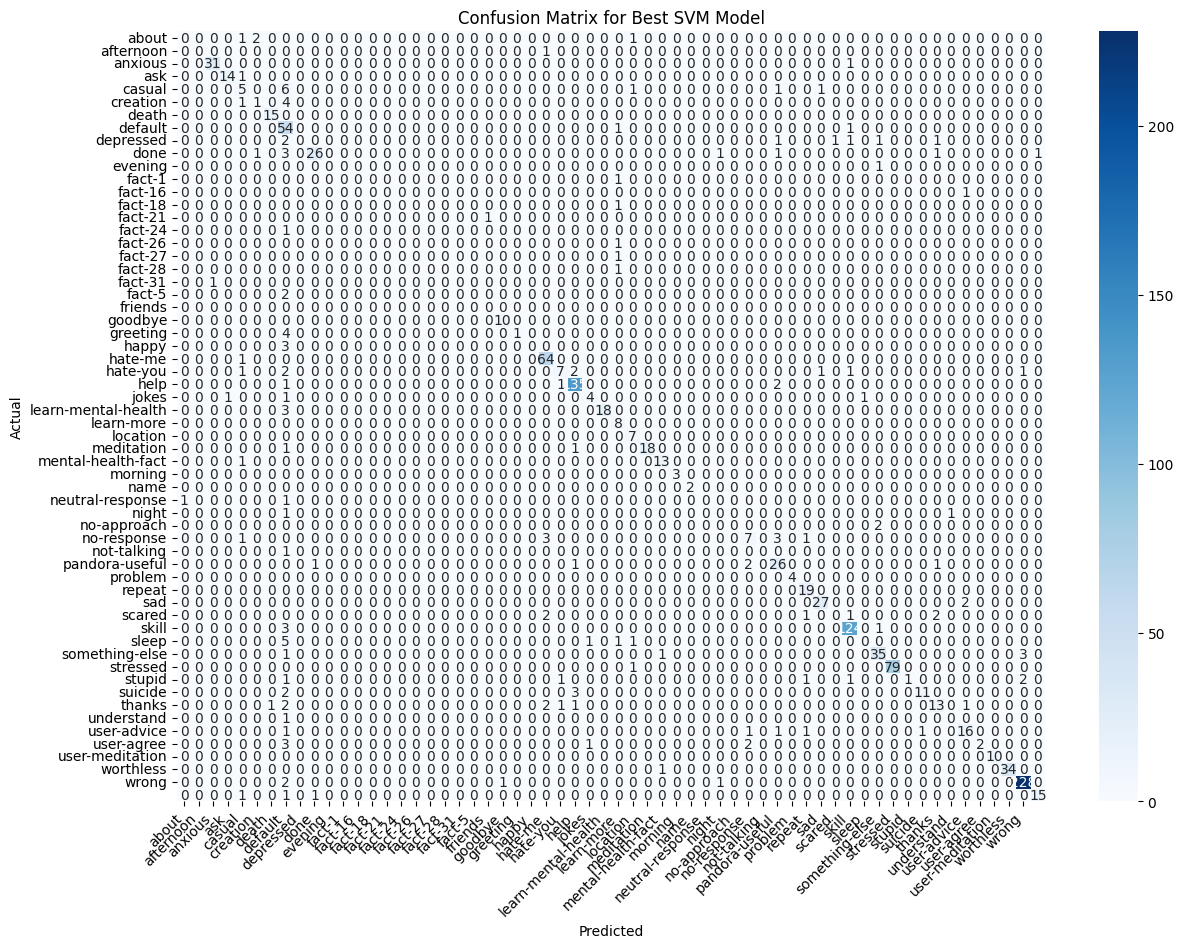

In [45]:
conf_matrix = confusion_matrix(y_test, svm_best_pred)
plt.figure(figsize=(14, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.inverse_transform(np.unique(y_test)), yticklabels=label_encoder.inverse_transform(np.unique(y_test)))
plt.title('Confusion Matrix for Best SVM Model')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.show()



## WordCloud for most common words in patterns

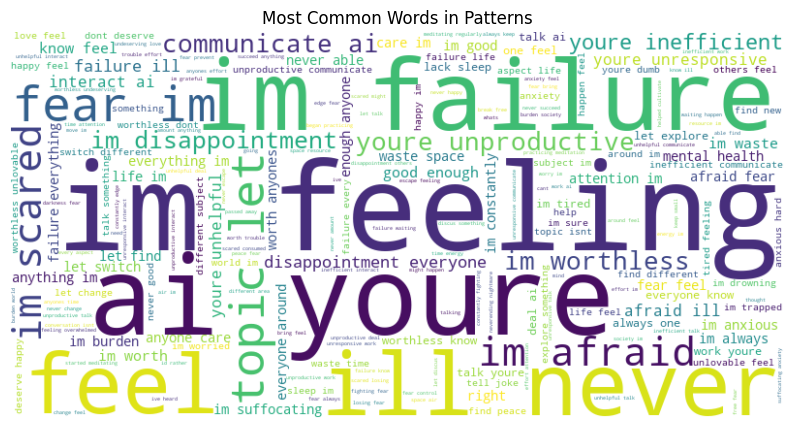

In [46]:
all_patterns = ' '.join(df['pattern_cleaned'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_patterns)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Common Words in Patterns')
plt.show()

## Deep Learning Model with LSTM

Epoch 1/5
79/79 - 87s - loss: 3.3305 - accuracy: 0.1918 - val_loss: 2.9219 - val_accuracy: 0.3461 - 87s/epoch - 1s/step
Epoch 2/5
79/79 - 69s - loss: 2.3570 - accuracy: 0.4538 - val_loss: 1.8924 - val_accuracy: 0.5699 - 69s/epoch - 874ms/step
Epoch 3/5
79/79 - 70s - loss: 1.6235 - accuracy: 0.6191 - val_loss: 1.4464 - val_accuracy: 0.6699 - 70s/epoch - 880ms/step
Epoch 4/5
79/79 - 69s - loss: 1.2127 - accuracy: 0.7356 - val_loss: 1.1550 - val_accuracy: 0.7602 - 69s/epoch - 872ms/step
Epoch 5/5
79/79 - 71s - loss: 0.9069 - accuracy: 0.8195 - val_loss: 0.9443 - val_accuracy: 0.8137 - 71s/epoch - 895ms/step


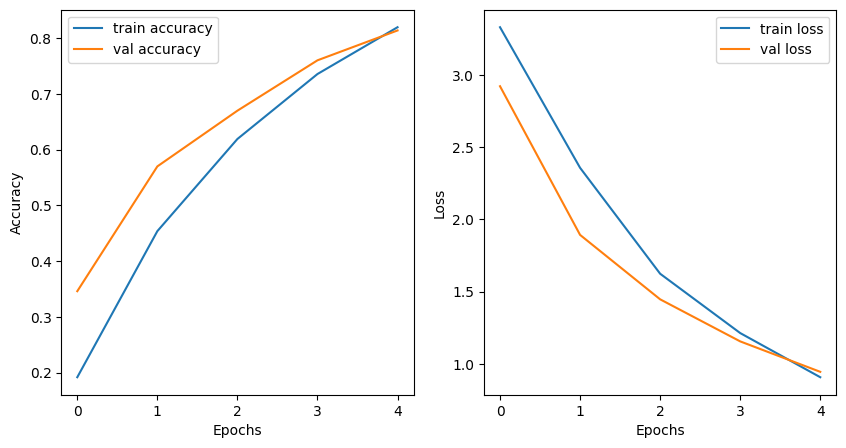

40/40 [==============================] - 3s 68ms/step
LSTM Model
Accuracy: 0.8137490007993605
Confusion Matrix:
 [[  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0  31 ...   0   0   0]
 ...
 [  0   0   0 ...  35   0   0]
 [  0   0   0 ...   0 228   0]
 [  0   0   0 ...   0   0  15]]
Classification Report:
                      precision    recall  f1-score   support

              about       0.00      0.00      0.00         4
          afternoon       0.00      0.00      0.00         1
            anxious       0.82      0.97      0.89        32
                ask       0.74      0.93      0.82        15
             casual       0.00      0.00      0.00        14
           creation       0.00      0.00      0.00         6
              death       1.00      0.93      0.97        15
            default       0.41      0.96      0.58        56
          depressed       0.00      0.00      0.00         7
               done       0.77      0.71      0.74        34

In [47]:
MAX_NB_WORDS = 5000
MAX_SEQUENCE_LENGTH = 250
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(df['pattern_cleaned'].values)
word_index = tokenizer.word_index
X_lstm = tokenizer.texts_to_sequences(df['pattern_cleaned'].values)
X_lstm = pad_sequences(X_lstm, maxlen=MAX_SEQUENCE_LENGTH)
y_lstm = pd.get_dummies(df['tag']).values

X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = train_test_split(X_lstm, y_lstm, test_size=0.2, random_state=42)

model_lstm = Sequential()
model_lstm.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH))
model_lstm.add(SpatialDropout1D(0.2))
model_lstm.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model_lstm.add(Dense(len(y_lstm[0]), activation='softmax'))
model_lstm.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model_lstm.fit(X_train_lstm, y_train_lstm, epochs=5, batch_size=64, validation_data=(X_test_lstm, y_test_lstm), verbose=2)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

y_test_lstm_pred = model_lstm.predict(X_test_lstm)
y_test_lstm_pred_class = np.argmax(y_test_lstm_pred, axis=1)
y_test_lstm_class = np.argmax(y_test_lstm, axis=1)

print("LSTM Model")
evaluate_model(model_lstm, X_test_lstm, y_test_lstm_class, y_test_lstm_pred_class)


## Conclusion 

The analysis provides insights into the distribution of tags, common patterns, and the performance of advanced classification models, including a deep learning model (LSTM).